## 09 회귀 실습 - 자전거 대여 수요 예측

### 데이터 클렌징 및 가공

In [1]:
#데이터 세트를 DataFrame으로 로드해 대략적으로 데이터 확인

#필요한 모듈 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#데이터 세트 불러온 후 살펴보기
bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
#문자열인 datetime 칼럼 가공하기

#문자열을 datetime타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

#datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)

bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
#datetime, casual, registered 칼럼 삭제
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


### 성능 평가 함수 생성

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#RMSLE 계산 함수 rmsle() 생성
#log값 변환 시 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#RMSE 계산 함수 rmse() 생성
#사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

#MSE, RMSE, RMSLE를 모두 계산하는 함수 evaluate_regr() 생성
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    #MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [6]:
#함수 rmsle() 생성에서 log값 변환 시 log() 함수나 mean_squared_log_error() 대신 log1p()를 이용하는 이유
#다음과 같은 rmsle 구현은 오버플로나 언드플로 오류를 발생하기 쉽습니다 (잘못된 예)
def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle = np.sqrt(mse)
    return rmsle

In [7]:
#올바른 예시
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [8]:
#회귀 예측

#필요 모듈 불러오기
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#X_features, y_target 설정, 학습/테스트용 데이터 세트로 분할
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

#회귀 모델 생성 후 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [9]:
#오류값이 가장 큰 순으로 5개 확인하는 함수 생성

def get_top_error_data(y_test, pred, n_tops=5):
    #DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    #예측값과 실제값의 차이가 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

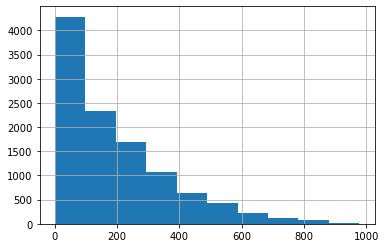

In [10]:
#Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하기

y_target.hist()

<AxesSubplot:>

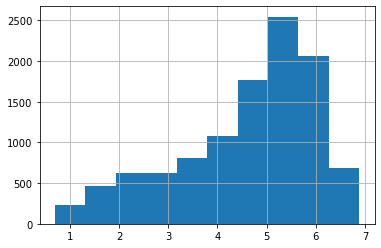

In [11]:
#로그 변환을 통해 왜곡된 값을 정규 분포 형태로 바꾸기

y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [12]:
#Target값 변환 후 다시 학습, 예측, 평가 수행

#타깃 칼럼인 count 값을 log1p()를 이용해 로그 변환
y_target_log = np.log1p(y_target)

#로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

#모델 생성 후 학습, 예측
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#테스트 데이터 세트의 Target 값과 예측값을 expm1()을 이용해 스케일 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

#평가
evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

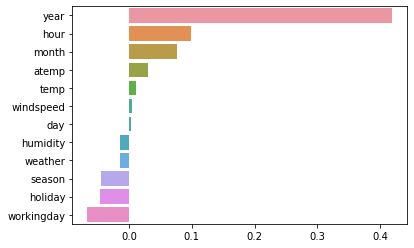

In [13]:
#각 피처의 회귀계수값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [14]:
#카테고리형 피처에 원-핫 인코딩 적용해 변환
X_features_ohe = pd.get_dummies(X_features, 
                                columns=['year', 'month', 'day', 'hour', 
                                         'holiday', 'workingday', 'season', 'weather'])
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


In [40]:
#카테고리형 피처에 원-핫 인코딩 적용해 변환
X_features_ohe = pd.get_dummies(X_features, 
                                columns=['year', 'month', 'day', 'hour', 
                                         'holiday', 'workingday', 'season', 'weather'])

#원-핫 인코딩이 적용된 피처 데이터 세트를 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                    test_size=0.3, random_state=0)

#모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하는 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
    

#LinearRegression, Ridge, Lasso 모델별로 평가 수행
from sklearn.linear_model import LinearRegression, Ridge, Lasso

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.689, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<AxesSubplot:>

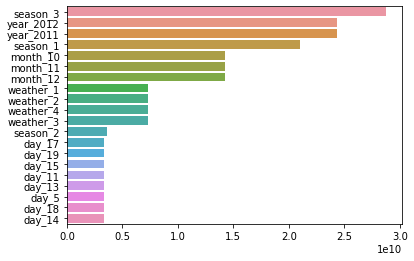

In [41]:
#원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처 시각화
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [42]:
import sklearn
sklearn.__version__

'0.23.2'

### LinearRegression ###
RMSLE: 0.589, RMSE: 97.483, MAE: 63.106


<AxesSubplot:>

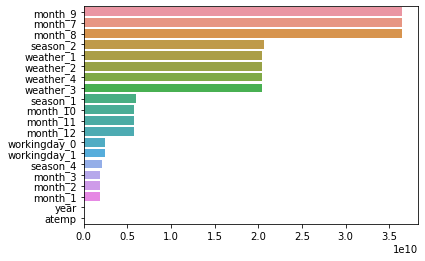

In [45]:
#year, day 칼럼을 제외한 6개의 칼럼만 원-핫 인코딩하면 교재와 비슷한 결과 나옴.
X_features_ohe = pd.get_dummies(X_features, columns=['month','hour', 'holiday',
                                              'workingday','season','weather'])
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, 
                                                    test_size=0.3, random_state=0)
lr_reg = LinearRegression()
get_model_predict(lr_reg, X_train, X_test, y_train, y_test, is_expm1=True)
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 회귀 트리를 이용한 회귀 예측

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#랜덤 포레스트, GBM, XGBoost, LightGBM 모델별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.150, MAE: 31.066
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.325, MAE: 32.740
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


In [31]:
import sklearn
sklearn.__version__

'0.23.2'